# showq analysis

## Preprocessing

The output of Adaptive Computing Moab `showq` command has to be preprocessed by `scripts/showq2csv.py`. It will create a CSV file that can be imported by pandas.

## Prerequisites

Import required modules.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%matplotlib inline

Ensure that modules are reloaded automatically when modified.

In [3]:
%load_ext autoreload
%autoreload 2

In [35]:
from lib.vsc.moab.nb_utils import extract_category
from lib.vsc.moab.metrics import state_distribution

## Analysis

The time stamp and date-time column should be parsed as data-time information, they are in the default format, so we don't need to use a custom formatter.

In [5]:
job_df = pd.read_csv('data/showq.csv', parse_dates=['time_stamp', 'datetime'])

In [6]:
job_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724 entries, 0 to 723
Data columns (total 9 columns):
category      724 non-null object
time_stamp    724 non-null datetime64[ns]
job_id        724 non-null object
user_id       724 non-null object
state         724 non-null object
procs         724 non-null int64
duration      724 non-null int64
datetime      724 non-null datetime64[ns]
derived       724 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 51.0+ KB


In [7]:
job_df.head()

,category,time_stamp,job_id,user_id,state,procs,duration,datetime,derived
0,ActiveJob,2018-04-11 09:10:00,20788108,vsc30675,Running,20,84579,2018-04-11 09:08:57,84642.0
1,ActiveJob,2018-04-11 09:10:00,20786357,vsc31046,Running,24,6428,2018-04-10 10:56:26,86442.0
2,ActiveJob,2018-04-11 09:10:00,20786387,vsc32051,Running,20,8543,2018-04-08 11:31:41,259242.0
3,ActiveJob,2018-04-11 09:10:00,20787980,vsc31935,Running,40,18715,2018-04-10 14:21:13,86442.0
4,ActiveJob,2018-04-11 09:10:00,20785171,vsc32218,Running,20,24000,2018-04-06 15:49:18,432042.0


In [8]:
running_df = extract_category(job_df, 'ActiveJob')

In [9]:
running_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226 entries, 0 to 225
Data columns (total 9 columns):
category          226 non-null object
time_stamp        226 non-null datetime64[ns]
job_id            226 non-null object
user_id           226 non-null object
state             226 non-null object
procs             226 non-null int64
remaining         226 non-null int64
start_time        226 non-null datetime64[ns]
walltime_limit    226 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 17.7+ KB


Verify that all jobs in active states are running.

In [10]:
running_df.state.drop_duplicates()

0    Running
Name: state, dtype: object

In [11]:
idle_df = extract_category(job_df, 'EligibleJob')

In [12]:
idle_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442 entries, 226 to 667
Data columns (total 9 columns):
category          442 non-null object
time_stamp        442 non-null datetime64[ns]
job_id            442 non-null object
user_id           442 non-null object
state             442 non-null object
procs             442 non-null int64
walltime_limit    442 non-null int64
queue_time        442 non-null datetime64[ns]
time_in_queue     442 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 34.5+ KB


Verify that eligible jobs are all in idle state.

In [13]:
idle_df.state.drop_duplicates()

226    Idle
Name: state, dtype: object

In [14]:
blocked_df = extract_category(job_df, 'BlockedJob')

In [15]:
blocked_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 668 to 723
Data columns (total 9 columns):
category          56 non-null object
time_stamp        56 non-null datetime64[ns]
job_id            56 non-null object
user_id           56 non-null object
state             56 non-null object
procs             56 non-null int64
walltime_limit    56 non-null int64
queue_time        56 non-null datetime64[ns]
time_in_queue     56 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 4.4+ KB


Check the states the blocked jobs are in.

In [16]:
blocked_df[['job_id', 'state']].groupby('state').count()

,job_id
state,
BatchHold,3
NotQueued,3
SystemHold,50


Count the number of jobs per user, and sort descending, and show top-10.

In [17]:
running_df[['user_id', 'job_id']].groupby('user_id').count().sort_values('job_id', ascending=False).head(10)

,job_id
user_id,
vsc31179,33
vsc32233,32
vsc31064,28
vsc31645,15
vsc31849,11
vsc30668,9
vsc31921,7
vsc31046,7
vsc31662,6


Analyze running jobs' remaining time.

In [18]:
running_df.remaining.apply(lambda x: x/3600).describe()

count    226.000000
mean      83.487179
std       99.543065
min        1.785556
25%       21.567222
50%       55.873194
75%       87.384653
max      488.802500
Name: remaining, dtype: float64

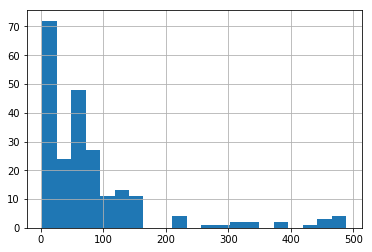

In [19]:
running_df.remaining.apply(lambda x: x/3600).hist(bins=21);

Compute the total work that still needs to be done by running jobs, expressed in core-hours.

In [20]:
(running_df.remaining*running_df.procs).sum(axis=0)/3600

562426.6330555555

Total work for the currently running jobs.

In [21]:
(running_df.walltime_limit*running_df.procs).sum()/3600

771443.91

Number of core currently running jobs.

In [22]:
running_df.procs.sum()

6713

Compute the total work that needs to be done by idle jobs, expressed in core-hours.

In [23]:
(idle_df.walltime_limit*idle_df.procs).sum(axis=0)/3600

501573.5333333333

What is the distribution of the number of processes for the jobs?

In [24]:
running_df.procs.describe()

count    226.000000
mean      29.703540
std       41.710278
min        1.000000
25%       20.000000
50%       20.000000
75%       24.000000
max      336.000000
Name: procs, dtype: float64

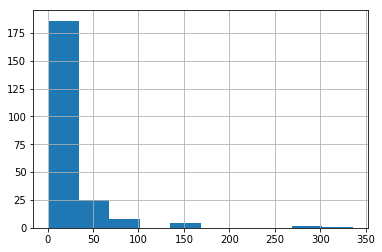

In [25]:
running_df.procs.hist(bins=10);

Who are the users that submit non-trivial jobs?

In [26]:
running_df[['user_id', 'procs']].query('procs > 100').groupby('user_id').count()

,procs
user_id,
vsc30626,4
vsc30637,2
vsc31487,1


What is the distribution of queue times?

In [27]:
idle_df.time_in_queue.describe()/3600

count       0.122778
mean       30.088469
std       104.644086
min         0.191944
25%        22.009722
50%        22.065833
75%        38.055556
max      2152.652778
Name: time_in_queue, dtype: float64

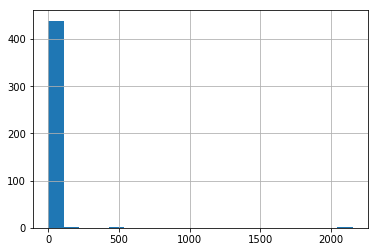

In [28]:
(idle_df.time_in_queue/3600).hist(bins=20);

What is the distribution of the jobs over the various states?

In [37]:
state_distr = state_distribution(job_df)
state_distr

,nr_jobs
state,
BatchHold,3
Idle,442
NotQueued,3
Running,226
SystemHold,50


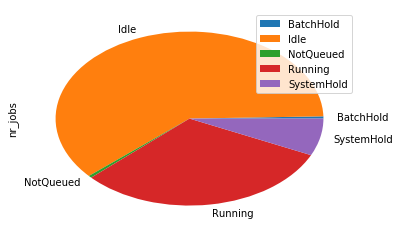

In [40]:
state_distr.plot(y='nr_jobs', kind='pie');

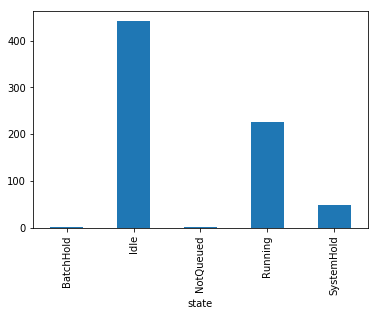

In [45]:
state_distr.plot(kind='bar', legend=None);